# **1. Install and Import Dependencies**  

In [ ]:
# Install necessary packages
!pip install numpy==1.24.3 matplotlib torch torchvision torchaudio scikit-learn pytransit
!pip install batman-package

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import batman
from sklearn.metrics import roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Mount Google Drive (for dataset storage)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Generate Transit Curves**


In [ ]:
def simulate_transit_curve(t, rp=0.1, a=15.0, inc=87, t0=0.0, noise=0.0005):
    """
    Simulate a transit light curve using batman.
    """
    params = batman.TransitParams()
    params.t0 = t0                      # Mid-transit time
    params.per = 1.0                    # Orbital period (days)
    params.rp = rp                      # Planet radius (in stellar radii)
    params.a = a                        # Semi-major axis (in stellar radii)
    params.inc = inc                    # Orbital inclination (degrees)
    params.ecc = 0.0                    # Eccentricity
    params.w = 90.0                     # Longitude of periastron
    params.limb_dark = "quadratic"      # Limb darkening model
    params.u = [0.1, 0.3]               # Limb darkening coefficients

    m = batman.TransitModel(params, t)
    flux = m.light_curve(params)
    # Add Gaussian noise
    flux += np.random.normal(0, noise, size=flux.shape)
    return flux

# **3. CNN Model for Transit Detection**

In [ ]:
class TransitClassifier(nn.Module):
    def __init__(self):
        super(TransitClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransitClassifier().to(device)

# **4. Create Synthetic Dataset**

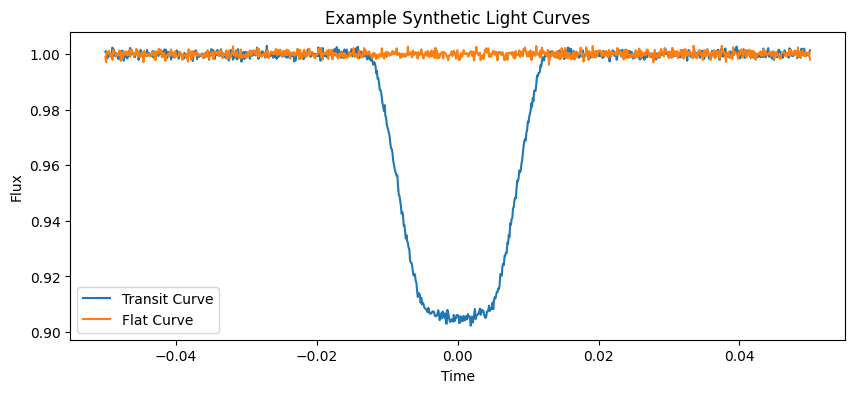

In [ ]:
def create_dataset(num_samples=3000, noise_level=0.001):
    """
    Generates a balanced dataset of synthetic transit curves and flat curves.
    Transit curves are simulated with random physical parameters.
    Non-transit curves are flat light curves with noise.
    """
    X, y = [], []
    t = np.linspace(-0.05, 0.05, 1000)
    for _ in range(num_samples):
        if np.random.rand() > 0.5:
            # Increase planet radius for a deeper transit
            rp = np.random.uniform(0.2, 0.4)
            a = np.random.uniform(10, 20)
            inc = np.random.uniform(85, 90)
            t0 = np.random.uniform(-0.02, 0.02)
            curve = simulate_transit_curve(t, rp=rp, a=a, inc=inc, t0=t0, noise=noise_level)
            label = 1
        else:  # Non-transit: flat curve with noise
            curve = np.ones_like(t) + np.random.normal(0, noise_level, size=t.shape)
            label = 0
        X.append(curve)
        y.append(label)
    return np.array(X), np.array(y)

# Optional: visualize some generated curves
if __name__ == "__main__":
    t = np.linspace(-0.05, 0.05, 1000)
    transit_example = simulate_transit_curve(t, rp=0.3, a=15, inc=88, t0=0.0, noise=0.001)
    flat_example = np.ones_like(t) + np.random.normal(0, 0.001, size=t.shape)

    plt.figure(figsize=(10,4))
    plt.plot(t, transit_example, label="Transit Curve")
    plt.plot(t, flat_example, label="Flat Curve")
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.legend()
    plt.title("Example Synthetic Light Curves")
    plt.show()

data, labels = create_dataset(num_samples=3000, noise_level=0.001)
data = torch.from_numpy(data.astype(np.float32)).unsqueeze(1)
labels = torch.from_numpy(labels.astype(np.float32)).unsqueeze(1)

dataset = TensorDataset(data, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# **5. Prepare Data for Training**

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

num_epochs = 50
best_val_acc = 0.0

# Directory to save the best model
output_dir = "/content/drive/My Drive/exoplanet_transit_model"
os.makedirs(output_dir, exist_ok=True)
best_model_path = os.path.join(output_dir, "transit_classifier_best.pth")

for epoch in range(num_epochs):
    model.train()
    total_train, correct_train, train_loss = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)

    train_loss /= total_train
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    total_val, correct_val, val_loss = 0, 0, 0.0
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item() * x.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == y).sum().item()
            total_val += y.size(0)

            probs = torch.sigmoid(outputs)
            all_probs.extend(probs.cpu().numpy().flatten())
            all_targets.extend(y.cpu().numpy().flatten())

    val_loss /= total_val
    val_acc = correct_val / total_val
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/50 | Train Acc: 0.5038 | Val Acc: 0.4750
Epoch 2/50 | Train Acc: 0.5142 | Val Acc: 0.4750
Epoch 3/50 | Train Acc: 0.4896 | Val Acc: 0.4750
Epoch 4/50 | Train Acc: 0.5167 | Val Acc: 0.5250
Epoch 5/50 | Train Acc: 0.4971 | Val Acc: 0.4750
Epoch 6/50 | Train Acc: 0.5117 | Val Acc: 0.5250
Epoch 7/50 | Train Acc: 0.5058 | Val Acc: 0.4750
Epoch 8/50 | Train Acc: 0.5042 | Val Acc: 0.5250
Epoch 9/50 | Train Acc: 0.4892 | Val Acc: 0.5250
Epoch 10/50 | Train Acc: 0.5162 | Val Acc: 0.5250
Epoch 11/50 | Train Acc: 0.5150 | Val Acc: 0.5250
Epoch 12/50 | Train Acc: 0.5196 | Val Acc: 0.6633
Epoch 13/50 | Train Acc: 0.5146 | Val Acc: 0.4750
Epoch 14/50 | Train Acc: 0.5088 | Val Acc: 0.4750
Epoch 15/50 | Train Acc: 0.5367 | Val Acc: 0.5250
Epoch 16/50 | Train Acc: 0.5125 | Val Acc: 0.6267
Epoch 17/50 | Train Acc: 0.5267 | Val Acc: 0.6900
Epoch 18/50 | Train Acc: 0.5425 | Val Acc: 0.5250
Epoch 19/50 | Train Acc: 0.5425 | Val Acc: 0.4750
Epoch 20/50 | Train Acc: 0.5629 | Val Acc: 0.5717
Epoch 21/

# **6. Confusion Matrix**

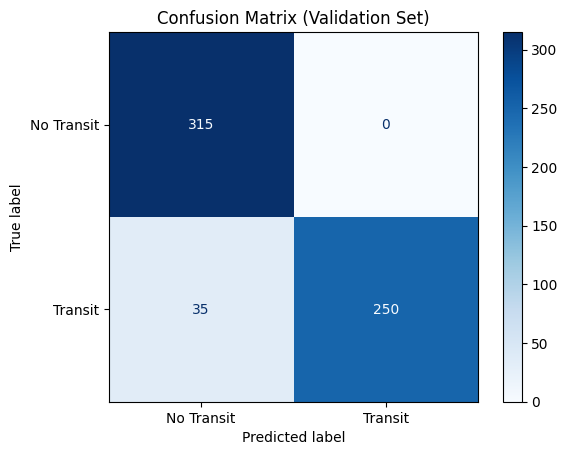

In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_targets_cm = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets_cm.extend(y.cpu().numpy().flatten())

cm = confusion_matrix(all_targets_cm, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Transit", "Transit"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()

# **7. Load Best Model & Final Evaluation (ROC Curve/AUC)**

Validation Accuracy (Best Model): 94.17%
Validation AUC (Best Model): 0.9666


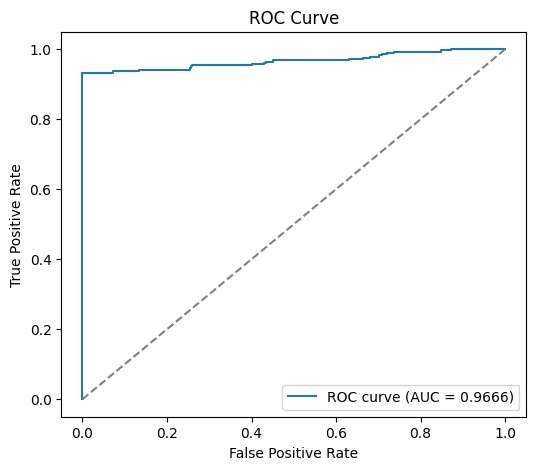

In [ ]:
# Load the best model checkpoint
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct, test_total = 0, 0
all_targets, all_probs = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        # Model outputs shape [batch, 1]
        outputs = model(x)

        # Convert logits to probabilities
        probs = torch.sigmoid(outputs).squeeze(1)  # shape [batch]

        # Binarize predictions at 0.5 threshold
        preds = (probs > 0.5).float()

        # Accumulate accuracy stats
        test_total += y.size(0)
        test_correct += (preds == y.squeeze(1)).sum().item()

        # Store probabilities and targets for ROC
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(y.squeeze(1).cpu().numpy())

test_accuracy = 100.0 * test_correct / test_total
print(f"Validation Accuracy (Best Model): {test_accuracy:.2f}%")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)
print(f"Validation AUC (Best Model): {roc_auc:.4f}")

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# **9. Inference on New Data**

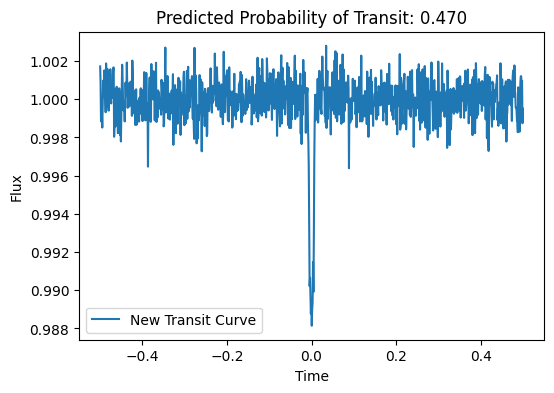

In [ ]:
# 9. Inference on New Data
time = np.linspace(-0.5, 0.5, 1000)
test_flux = simulate_transit_curve(time, noise=0.001)

# Shape: [1, 1, 1000] for a single sample
test_tensor = torch.tensor(test_flux, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(test_tensor)
    prob = torch.sigmoid(logits).item()

plt.figure(figsize=(6, 4))
plt.plot(time, test_flux, label="New Transit Curve")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"Predicted Probability of Transit: {prob:.3f}")
plt.legend()
plt.show()